In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import scoreatpercentile, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
patients_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_preictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_ictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patients_postictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034","sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsASL_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient007","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_preictal = ["sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013", "sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_ictal = ["sub-patient001","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patientsASL_postictal = ["sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034", "sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsCVR_interictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_preictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_ictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"] # !!! SUB-PATIENT004 NOT INCLUDED FOR NOW
patientsCVR_postictal = ["sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]

In [3]:
# we only want patients with vascular AND neuronal maps

def intersection(list1,list2):
    return [element for element in list1 if element in list2]

neurowASL_interictal = intersection(patients_interictal,patientsASL_interictal)
#print(len(neurowASL_interictal))
neurowASL_preictal = intersection(patients_preictal,patientsASL_preictal)
#print(len(neurowASL_preictal))
neurowASL_ictal = intersection(patients_ictal,patientsASL_ictal)
#print(len(neurowASL_ictal))
neurowASL_postictal = intersection(patients_postictal,patientsASL_postictal)
#print(len(neurowASL_postictal))

neurowCVR_interictal = intersection(patients_interictal,patientsCVR_interictal)
#print(len(neurowCVR_interictal))
neurowCVR_preictal = intersection(patients_preictal,patientsCVR_preictal)
#print(len(neurowCVR_preictal))
neurowCVR_ictal = intersection(patients_ictal,patientsCVR_ictal)
#print(len(neurowCVR_ictal))
neurowCVR_postictal = intersection(patients_postictal,patientsCVR_postictal)
#print(len(neurowCVR_postictal))


# Patients Correlations

In [4]:
def voxelwise_patients(patientlist, session, vasclabel):
    path = "/home/bpereira/func/"
    ses = session
    restpath = f"{ses}/{ses}-proc.feat/maps_to_corr/"

    lin_adjr2_happy = []
    quad_adjr2_happy = []
    lin_adjr2_angry = []
    quad_adjr2_angry = []
    lin_adjr2_vis = []
    quad_adjr2_vis = []

    for sub in patientlist:
        happy_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE8_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE9_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE4_smoothed8.nii")

        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
            print("entered")
    
        # load data
        happynii = nib.load(happy_path)
        happy = happynii.get_fdata()

        angrynii = nib.load(angry_path)
        angry = angrynii.get_fdata()

        visnii = nib.load(vis_path)
        vis = visnii.get_fdata()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata()

        # cut due to ASLs FOV

        cuthappy = happy[:,:,16:68]
        cutangry = angry[:,:,16:68]
        cutvis = vis[:,:,16:68]

        cutvasc = vasc[:,:,16:68]

        # remove outliers, for now not in use
        """ 
        qhappy1 = scoreatpercentile(cuthappy,1,axis=0)
        qhappy99 = scoreatpercentile(cuthappy,99, axis=0)

        qangry1 = scoreatpercentile(cutangry,1,axis=0)
        qangry99 = scoreatpercentile(cutangry,99,axis=0)
        
        qvis1 = scoreatpercentile(cutvis,1,axis=0)
        qvis99 = scoreatpercentile(cutvis,99,axis=0)

        qvasc1 = scoreatpercentile(cutvasc,1,axis=0)
        qvasc99 = scoreatpercentile(cutvasc,99,axis=0)

        cuthappy_masked = np.where((cuthappy >= qhappy1) & (cuthappy <= qhappy99), cuthappy, np.nan) # nan ou 0? o que fazer para manter a shape
        cutangry_masked = np.where((cutangry >= qangry1) & (cutangry <= qangry99), cutangry, np.nan)
        cutvis_masked = np.where((cutvis >= qvis1) & (cutvis <= qvis99), cutvis, np.nan)
        cutvasc_masked = np.where((cutvasc >= qvasc1) & (cutvasc <= qvasc99), cutvasc, np.nan) """
        
        # linear correlations

        # happy vs vasc

        slopeh, intercepth, r_valueh, p_valueh, std_errh = linregress(cuthappy.flatten(), cutvasc.flatten())
        r2h = r_valueh**2
        adj_r2h = 1 - (1 - r2h) * (len(cutvasc) - 1) / (len(cutvasc)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_happy += [adj_r2h]

        # angry vs vasc 

        slopea, intercepta, r_valuea, p_valuea, std_erra = linregress(cutangry.flatten(), cutvasc.flatten())
        r2a = r_valuea**2
        adj_r2a = 1 - (1 - r2a) * (len(cutvasc) - 1) / (len(cutvasc)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_angry += [adj_r2a]

        # vis vs vasc 

        slopev, interceptv, r_valuev, p_valuev, std_errv = linregress(cutvis.flatten(), cutvasc.flatten())
        r2v = r_valuev**2
        adj_r2v = 1 - (1 - r2v) * (len(cutvasc.flatten()) - 1) / (len(cutvasc.flatten())  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_vis += [adj_r2v]

        # quadratic correlations

        # happy vs vasc 

        hcoefs = np.polyfit(cuthappy.flatten(),cutvasc.flatten(),deg=2)
        yfitquad = np.polyval(hcoefs, cuthappy.flatten())
        yresidquad = cutvasc.flatten() - yfitquad
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(cutvasc.flatten()) - 1) * np.var(cutvasc.flatten())
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquadh = 1 - (1 - rsqquad) * (len(cutvasc.flatten()) - 1) / (len(cutvasc.flatten()) - 2 - 1) # p=2, quadratic

        quad_adjr2_happy += [rsq_adjquadh]

        # angry vs vasc

        acoefs = np.polyfit(cutangry.flatten(),cutvasc.flatten(),deg=2)
        yfitquad = np.polyval(acoefs, cutangry.flatten())
        yresidquad = cutvasc.flatten() - yfitquad
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(cutvasc.flatten()) - 1) * np.var(cutvasc.flatten())
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquada = 1 - (1 - rsqquad) * (len(cutvasc.flatten()) - 1) / (len(cutvasc.flatten()) - 2 - 1) # p=2, quadratic

        quad_adjr2_angry += [rsq_adjquada]

        # vis vs vasc 

        vcoefs = np.polyfit(cutvis.flatten(),cutvasc.flatten(),deg=2)
        yfitquad = np.polyval(vcoefs, cutvis.flatten())
        yresidquad = cutvasc.flatten() - yfitquad
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(cutvasc.flatten()) - 1) * np.var(cutvasc.flatten())
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquadv = 1 - (1 - rsqquad) * (len(cutvasc.flatten()) - 1) / (len(cutvasc.flatten()) - 2 - 1) # p=2, quadratic

        quad_adjr2_vis += [rsq_adjquadv]        

    return lin_adjr2_happy,lin_adjr2_angry,lin_adjr2_vis,quad_adjr2_happy,quad_adjr2_angry,quad_adjr2_vis


## ASL

In [5]:
# ASL correlations 

# interictal

[ASLlinH_int,ASLlinA_int,ASLlinV_int,ASLquadH_int,ASLquadA_int,ASLquadV_int] = voxelwise_patients(neurowASL_interictal,'ses-interictal','ASL')

# preictal

[ASLlinH_preict,ASLlinA_preict,ASLlinV_preict,ASLquadH_preict,ASLquadA_preict,ASLquadV_preict] = voxelwise_patients(neurowASL_preictal,'ses-preictal','ASL')

# ictal 

[ASLlinH_ict,ASLlinA_ict,ASLlinV_ict,ASLquadH_ict,ASLquadA_ict,ASLquadV_ict] = voxelwise_patients(neurowASL_ictal,'ses-ictal','ASL')

# postictal

[ASLlinH_postict,ASLlinA_postict,ASLlinV_postict,ASLquadH_postict,ASLquadA_postict,ASLquadV_postict] = voxelwise_patients(neurowASL_postictal,'ses-postictal','ASL')



Text(0.5, 1.0, 'Voxelwise correlation Between Neuronal maps and ASL (Postictal)')

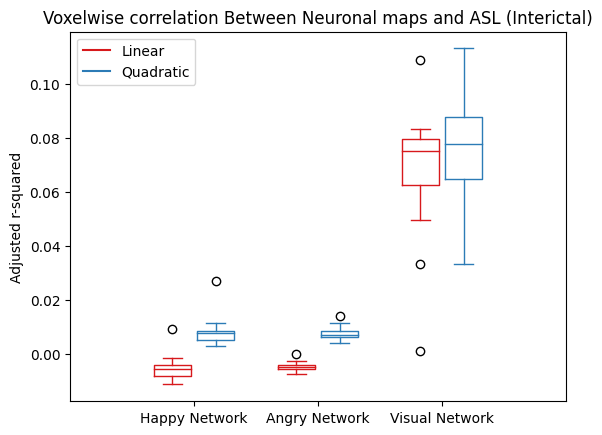

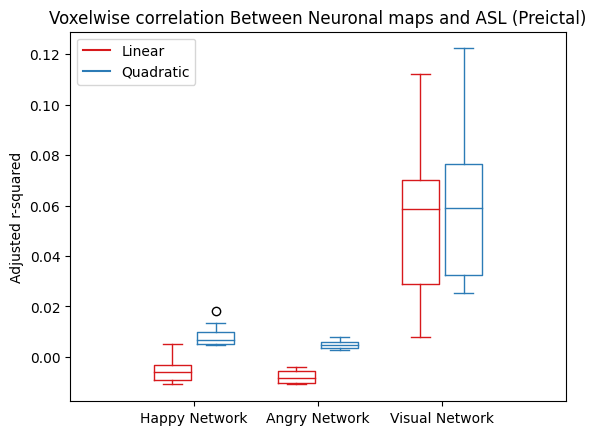

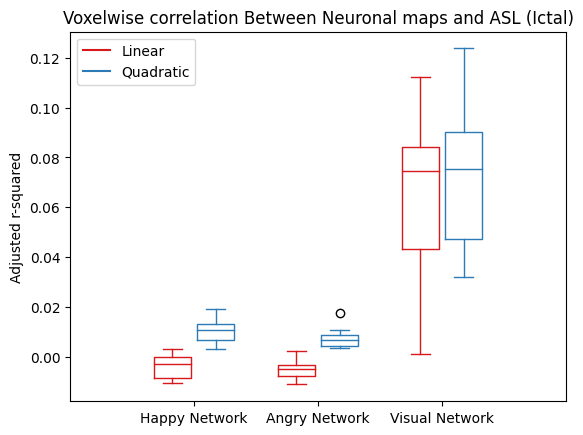

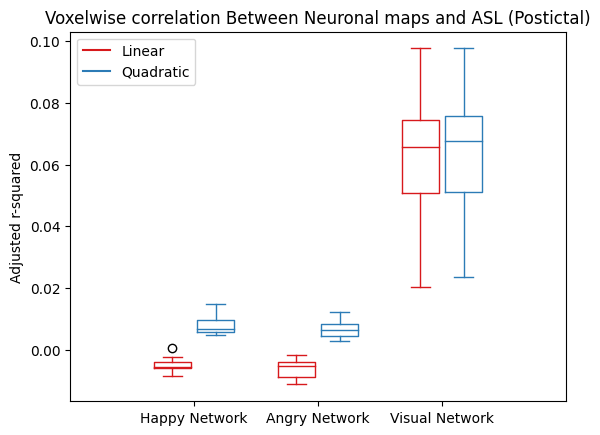

In [6]:
ticks = ['Happy Network', 'Angry Network', 'Visual Network']

linear_plotint = plt.boxplot([ASLlinH_int,ASLlinA_int,ASLlinV_int],positions=np.array(np.arange(len([ASLlinH_int,ASLlinA_int,ASLlinV_int])))*2.0-0.35, widths=0.6)
quad_plotint = plt.boxplot([ASLquadH_int,ASLquadA_int,ASLquadV_int],positions=np.array(np.arange(len([ASLquadH_int,ASLquadA_int,ASLquadV_int])))*2.0+0.35,widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()

define_box_properties(linear_plotint, '#D7191C', 'Linear')
define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic')

plt.ylabel('Adjusted r-squared')
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)

plt.title('Voxelwise correlation Between Neuronal maps and ASL (Interictal)')

plt.figure()

linear_plotpreict = plt.boxplot([ASLlinH_preict,ASLlinA_preict,ASLlinV_preict],positions=np.array(np.arange(len([ASLlinH_preict,ASLlinA_preict,ASLlinV_preict])))*2.0-0.35, widths=0.6)
quad_plotpreict = plt.boxplot([ASLquadH_preict,ASLquadA_preict,ASLquadV_preict],positions=np.array(np.arange(len([ASLquadH_preict,ASLquadA_preict,ASLquadV_preict])))*2.0+0.35,widths=0.6)

define_box_properties(linear_plotpreict, '#D7191C', 'Linear')
define_box_properties(quad_plotpreict, '#2C7BB6', 'Quadratic')

plt.ylabel('Adjusted r-squared')
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)

plt.title('Voxelwise correlation Between Neuronal maps and ASL (Preictal)')

plt.figure()

linear_plotict = plt.boxplot([ASLlinH_ict,ASLlinA_ict,ASLlinV_ict],positions=np.array(np.arange(len([ASLlinH_ict,ASLlinA_ict,ASLlinV_ict])))*2.0-0.35, widths=0.6)
quad_plotict = plt.boxplot([ASLquadH_ict,ASLquadA_ict,ASLquadV_ict],positions=np.array(np.arange(len([ASLquadH_ict,ASLquadA_ict,ASLquadV_ict])))*2.0+0.35,widths=0.6)

define_box_properties(linear_plotict, '#D7191C', 'Linear')
define_box_properties(quad_plotict, '#2C7BB6', 'Quadratic')

plt.ylabel('Adjusted r-squared')
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)

plt.title('Voxelwise correlation Between Neuronal maps and ASL (Ictal)')

plt.figure()

linear_plotpostict = plt.boxplot([ASLlinH_postict,ASLlinA_postict,ASLlinV_postict],positions=np.array(np.arange(len([ASLlinH_postict,ASLlinA_postict,ASLlinV_postict])))*2.0-0.35, widths=0.6)
quad_plotpostict = plt.boxplot([ASLquadH_postict,ASLquadA_postict,ASLquadV_postict],positions=np.array(np.arange(len([ASLquadH_postict,ASLquadA_postict,ASLquadV_postict])))*2.0+0.35,widths=0.6)

define_box_properties(linear_plotpostict, '#D7191C', 'Linear')
define_box_properties(quad_plotpostict, '#2C7BB6', 'Quadratic')

plt.ylabel('Adjusted r-squared')
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)

plt.title('Voxelwise correlation Between Neuronal maps and ASL (Postictal)')

## CVR